In [68]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

'''All equations are per-unit-area (µA/cm², mS/cm², µF/cm²)
and parameters are adapted from Pospischil et al. (2008)
with unit normalization for self-consistency.'''




'All equations are per-unit-area (µA/cm², mS/cm², µF/cm²)\nand parameters are adapted from Pospischil et al. (2008)\nwith unit normalization for self-consistency.'

In this Notebook I will implement  Hodking_Huxley type models. I will simulate spike-frequency
adaptation, variable firing thresholds bursting and subthreshold oscillations in 
Regular Spiking Neurons
Bursting neurons and
Low Treshhold Soiking Neurons.
I am using the models decribed the 2008 Pospischil paper

First I will implement the basic common channel kinetics from HH models for basic Action Potential generation:

In [69]:

# Basic Hodgkin–Huxley rate functions

def alpha_m(V, VT): return -0.32*(V - VT - 13)/(np.exp(-(V - VT - 13)/4) - 1 + 1e-12)
def beta_m(V, VT):  return  0.28*(V - VT - 40)/(np.exp( (V - VT - 40)/5) - 1 + 1e-12)
def alpha_h(V, VT): return  0.128*np.exp(-(V - VT - 17)/18)
def beta_h(V, VT):  return  4.0/(1 + np.exp(-(V - VT - 40)/5))
def alpha_n(V, VT): return -0.032*(V - VT - 15)/(np.exp(-(V - VT - 15)/5) - 1 + 1e-12)
def beta_n(V, VT):  return  0.5*np.exp(-(V - VT - 10)/40)

def gate_inf_tau(a, b): # steady-state value and time constant for a gating variable
    
    inf = a / (a + b)
    tau = 1.0 / (a + b)
    return inf, tau


With these basic rate functions I can basic basic behaviour like Hodking and Huxley observed dependent on the basic Sodium and Potasium ion channels. 
In this project however, I want to model special behaviours. These are realized by different ion current due to additional ion channels:

IM, a slow K+ current for adaptation
IL, a high-threshold Ca2+ current for bursting Cells
IT, a low-threshold Ca+ current that leads to Bursting (rebound bursts) in LTS cells.

Here are the respective kinetics:

In [70]:
#IM
def p_inf_tau(V, tau_max):
    p_inf = 1/(1 + np.exp(-(V + 35)/10))
    tau_p = tau_max / (3.3*np.exp((V + 35)/20) + np.exp(-(V + 35)/20))
    return p_inf, tau_p

#IL
def q_inf_tau(V):
    aq = 0.055*(-27 - V)/(np.exp((-27 - V)/3.8)-1 + 1e-12)
    bq = 0.94*np.exp((-75 - V)/17)
    return gate_inf_tau(aq, bq)

def r_inf_tau(V):
    ar = 0.000457*np.exp((-13 - V)/50)
    br = 0.0065/(np.exp((-15 - V)/28)+1)
    return gate_inf_tau(ar, br)

# IT
def s_inf_LTS(V, Vx):  # fast activation treated as instantaneous
    return 1/(1 + np.exp(-(V + Vx + 57)/6.2))

def u_inf_tau_LTS(V, Vx):
    u_inf = 1/(1 + np.exp((V + Vx + 81)/4))
    tau_u = (30.8 + (211.4 + np.exp((V + Vx + 113.2)/5))) / (3.7*(1 + np.exp((V + Vx + 84)/3.2)))
    return u_inf, tau_u



In [71]:
# Deifning constants from the paper

# Reversal potentials for ions in mV
ENa = 50
EK =  -90.0
ECa = 120.0   

Cm = 1.0  # µF/cm² per-area capacitance

In [72]:
# Here I initilize helper functions that compute steady-state gate values at rest.def init_RS_like(Vrest, VT, tau_max):

def init_RS_like(Vrest, VT, tau_max):
    am,bm = alpha_m(Vrest,VT), beta_m(Vrest,VT)
    ah,bh = alpha_h(Vrest,VT), beta_h(Vrest,VT)
    an,bn = alpha_n(Vrest,VT), beta_n(Vrest,VT)
    m0,_ = gate_inf_tau(am,bm)
    h0,_ = gate_inf_tau(ah,bh)
    n0,_ = gate_inf_tau(an,bn)
    p0,_ = p_inf_tau(Vrest,tau_max)
    return [m0,h0,n0,p0]

def init_IB(Vrest, VT, tau_max):
    m0,h0,n0,p0 = init_RS_like(Vrest,VT,tau_max)
    q0,_ = q_inf_tau(Vrest)
    r0,_ = r_inf_tau(Vrest)
    return [m0,h0,n0,p0,q0,r0]

def init_LTS(Vrest, VT, Vx):
    m0,h0,n0,p0 = init_RS_like(Vrest,VT,tau_max=500)
    u0,_ = u_inf_tau_LTS(Vrest,Vx)
    return [m0,h0,n0,p0,u0]

Now I can begin with modeling the actual cells. 
First a Regular Spiking Pyramidal Neuron with spike-frequency adaptation.
It is based on recordings of rat somatosensory cortex
in vitro.
It uses the the IM current for for slow adaptation; produces spike-frequency adaptation.
The model with it's parameters is described in Fig.2


In [73]:
# the parameters for that model, I had to convert them from  ~ S/cm² to mS/cm² and rounded them
RS_params = dict(gNa=50.0,gKd=6.0,gleak=0.02,Eleak=-70.3,VT=-56.2,gM=0.075,tau_max=608)

def RS_exc(t, y, Iinj, pars):
    
    V, m, h, n, p = y
    
    gNa,gKd,gleak,gM = pars['gNa'], pars['gKd'], pars['gleak'], pars['gM']
    Eleak,VT,tau_max = pars['Eleak'], pars['VT'], pars['tau_max']
    
    m_inf,tau_m = gate_inf_tau(alpha_m(V,VT), beta_m(V,VT))
    h_inf,tau_h = gate_inf_tau(alpha_h(V,VT), beta_h(V,VT))
    n_inf,tau_n = gate_inf_tau(alpha_n(V,VT), beta_n(V,VT))
    p_inf,tau_p = p_inf_tau(V, tau_max)
    
    INa = gNa*m**3*h*(V-ENa)
    IKd = gKd*n**4*(V-EK)
    IM  = gM*p*(V-EK) #essential component!
    Ileak = gleak*(V-Eleak)
    
    dVdt = (-INa-IKd-IM-Ileak+Iinj(t))/Cm
    dmdt,dhdt,dndt,dpdt = (m_inf-m)/tau_m,(h_inf-h)/tau_h,(n_inf-n)/tau_n,(p_inf-p)/tau_p
    
    return np.array([dVdt,dmdt,dhdt,dndt,dpdt], dtype=float)

Now, model for a intrsinsically Bursting based on recordings of cat visual cortex neurons in vivo. From Fig.6
Add IL (L-type Ca²⁺ current).
Bursting occurs from slow calcium activation/inactivation interplay. Also inludes IM so also adapting.


In [74]:
# Bursting
IB_params = dict(gNa=50.0,gKd=4.2,gleak=0.10,Eleak=-75,VT=-58,gM=0.042,tau_max=1000,gL=0.12)

def IB_cell(t, y, Iinj, pars):
    V, m, h, n, p, q, r = y
    
    gNa,gKd,gleak,gM,gL = pars['gNa'],pars['gKd'],pars['gleak'],pars['gM'],pars['gL']
    Eleak,VT,tau_max = pars['Eleak'],pars['VT'],pars['tau_max']
    
    m_inf,tau_m = gate_inf_tau(alpha_m(V,VT), beta_m(V,VT))
    h_inf,tau_h = gate_inf_tau(alpha_h(V,VT), beta_h(V,VT))
    n_inf,tau_n = gate_inf_tau(alpha_n(V,VT), beta_n(V,VT))
    p_inf,tau_p = p_inf_tau(V,tau_max)
    q_inf,tau_q = q_inf_tau(V)
    r_inf,tau_r = r_inf_tau(V)
    
    INa = gNa*m**3*h*(V-ENa)
    IKd = gKd*n**4*(V-EK)
    IM  = gM*p*(V-EK)
    IL  = gL*q**2*r*(V-ECa)
    Ileak = gleak*(V-Eleak)
    
    dVdt = (-INa-IKd-IM-IL-Ileak+Iinj(t))/Cm
    dmdt,dhdt,dndt,dpdt,dqdt,drdt = (m_inf-m)/tau_m,(h_inf-h)/tau_h,(n_inf-n)/tau_n,(p_inf-p)/tau_p,(q_inf-q)/tau_q,(r_inf-r)/tau_r
    
    return np.array([dVdt,dmdt,dhdt,dndt,dpdt,dqdt,drdt], dtype=float)


The last cell type is a Low-threshold spiking neuron with T-Type  Ca+ currents. So it shows busrting after hyperpolarization.
based on recordings based on recordings of rebound bursting cell of cat association cortex in vivo. Fig.8


In [75]:
# LTS: Low-Threshold-Spiking inhibitory neuron
LTS_params = dict(gNa=50.0,gKd=4.0,gleak=0.019,Eleak=-50,VT=-50,gM=0.028,gT=0.40,Vx=-7)
def LTS_cell(t, y, Iinj, pars):
    
    V, m, h, n, p, u = y
    
    gNa,gKd,gleak,gM,gT = pars['gNa'],pars['gKd'],pars['gleak'],pars['gM'],pars['gT']
    Eleak,VT,Vx = pars['Eleak'],pars['VT'],pars['Vx']
    
    m_inf,tau_m = gate_inf_tau(alpha_m(V,VT), beta_m(V,VT))
    h_inf,tau_h = gate_inf_tau(alpha_h(V,VT), beta_h(V,VT))
    n_inf,tau_n = gate_inf_tau(alpha_n(V,VT), beta_n(V,VT))
    
    p_inf,tau_p = p_inf_tau(V, tau_max=500)
    s_inf = s_inf_LTS(V,Vx)
    u_inf,tau_u = u_inf_tau_LTS(V,Vx)
    
    INa = gNa*m**3*h*(V-ENa)
    IKd = gKd*n**4*(V-EK)
    IM  = gM*p*(V-EK)
    IT  = gT*(s_inf**2)*u*(V-ECa)
    Ileak = gleak*(V-Eleak)
    dVdt = (-INa-IKd-IM-IT-Ileak+Iinj(t))/Cm
    dmdt,dhdt,dndt,dpdt,dudt = (m_inf-m)/tau_m,(h_inf-h)/tau_h,(n_inf-n)/tau_n,(p_inf-p)/tau_p,(u_inf-u)/tau_u
    return np.array([dVdt,dmdt,dhdt,dndt,dpdt,dudt], dtype=float)




In [103]:
# this provides the injected current specific for each cell type
def step_current_RS(t):
    return 6.0 if 50<t<250 else 0.0

def step_current_IB(t):
    return 8.0 if 50<t<250 else 0.0

def step_current_LTS(t):
    if 50<t<150: return -2.5
    elif 200<t<280: return 5.0
    else: return 0.0

#for sumulation. I use solve_ivp instead of euler method for more stabilty
def run(model, params, y0, Iinj, t_end=320):
    t_eval = np.arange(0,t_end,0.01)
    sol = solve_ivp(model,(0,t_end),y0,t_eval=t_eval,args=(Iinj,params),max_step=0.02)
    return sol.t, sol.y[0]


I want to track the F-I Curve, so how the firing rate depends on the current. For this is the next cell. It runs each cell for multiple steady depolarizing currents.

Counts threshold crossings to estimate firing frequency to build a F–I curve.

In [101]:
def detect_spikes(V, t, threshold=0):

    crossings = np.where((V[:-1]<threshold)&(V[1:]>=threshold))[0]
    return t[crossings]

def compute_fI(model, params, y0_func, I_values, tstim=(50,250), t_end=300):
    freqs = []
    for Iamp in I_values:
        def Iinj(t):
            return Iamp if tstim[0]<t<tstim[1] else 0.0
        y0 = y0_func()
        t, V = run(model, params, y0, Iinj, t_end)
        spikes = detect_spikes(V, t)
        if len(spikes)>=2:
            isi = np.diff(spikes)
            f = 1000/np.mean(isi)  #
        else:
            f = 0
        freqs.append(f)
    return np.array(freqs)


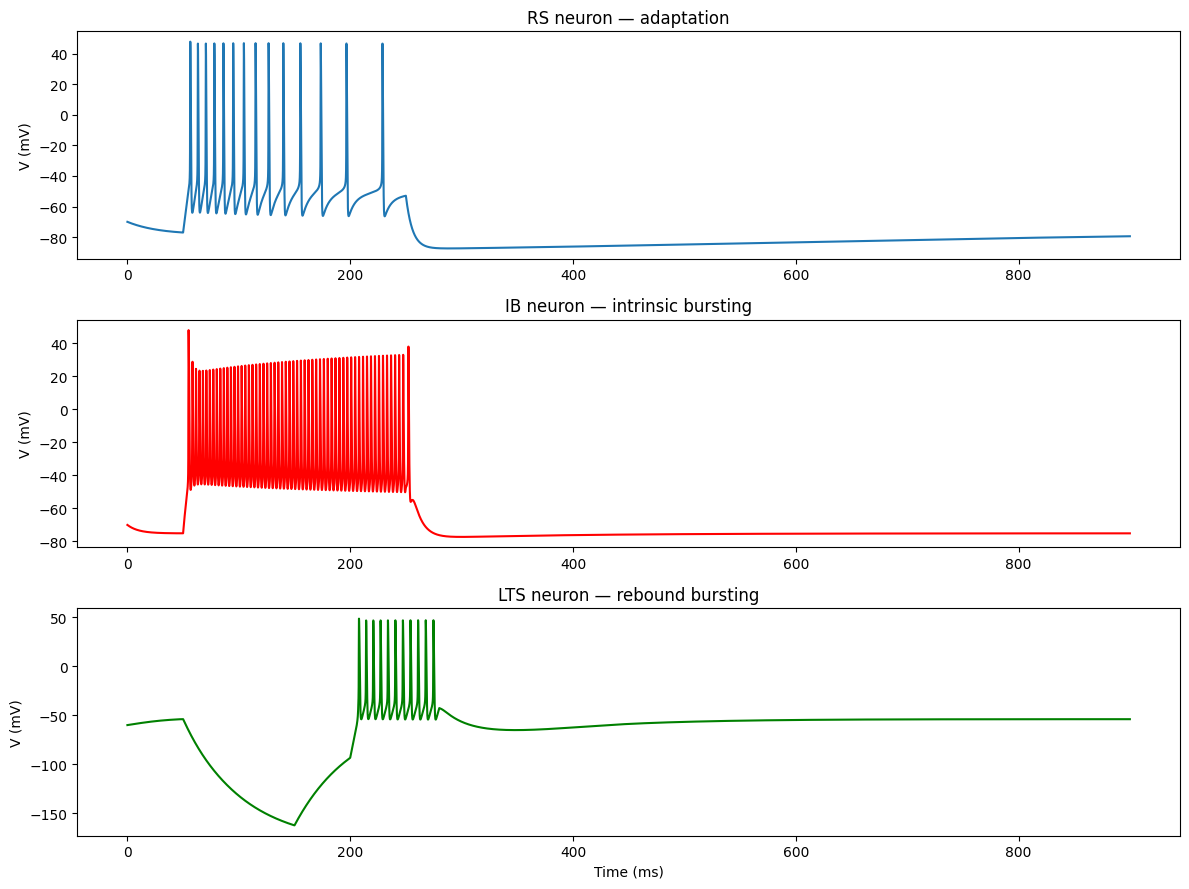

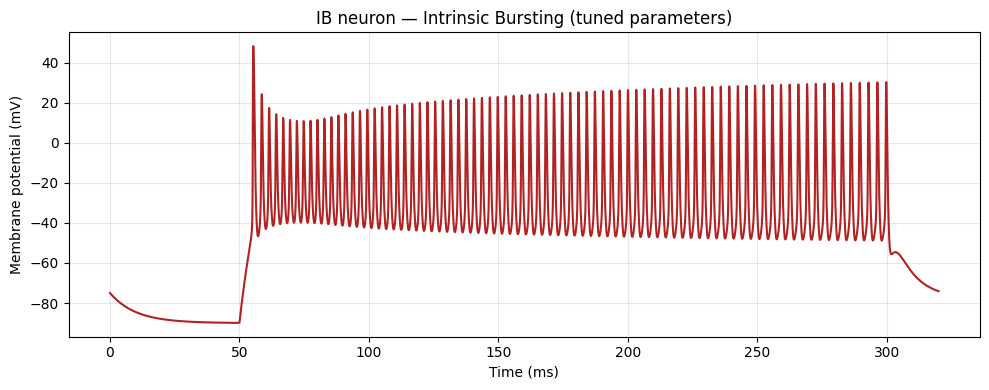

In [102]:
'Now I can begin running the models'


#to play paramerters
RS_params = dict(gNa=50.0,gKd=6.0,gleak=0.02,Eleak=-70.3,VT=-56.2,gM=0.5,tau_max=3000)
IB_params = dict(gNa=50.0,gKd=4.2,gleak=0.50,Eleak=-75,VT=-58,gM=0.042,tau_max=1000,gL=0.12)
LTS_params = dict(gNa=50.0,gKd=4.0,gleak=0.019,Eleak=-50,VT=-50,gM=0.028,gT=0.40,Vx=-7)

IB_params = dict(
    gNa=50.0,     # mS/cm² (same scale as your code)
    gKd=3.8,      # ↓ from 4.2 to ease repolarization, favors burst
    gleak=0.10,   # mS/cm²
    Eleak=-75.0,  # mV (matches Fig. 6)
    VT=-58.0,     # mV
    gM=0.030,     # ↓ from 0.042 so adaptation doesn't kill the burst
    tau_max=1000.0,  # ms (as in Fig. 6)
    gL=0.20       # ↑ from 0.12 to strengthen L-type plateau
)



IB_params_bursty = dict(
    gNa=50.0,     # mS/cm² (same scale as your code)
    gKd=3.8,      # ↓ from 4.2 to ease repolarization, favors burst
    gleak=0.10,   # mS/cm²
    Eleak=-75.0,  # mV (matches Fig. 6)
    VT=-58.0,     # mV
    gM=0.030,     # ↓ from 0.042 so adaptation doesn't kill the burst
    tau_max=1000.0,  # ms (as in Fig. 6)
    gL=0.20       # ↑ from 0.12 to strengthen L-type plateau
)


def step_current_IB_burst(t):
    if 0 < t < 50:       # pre-pulse to deinactivate r
        return -1.5
    elif 50 < t < 300:   # strong depolarizing step
        return 10.0
    else:
        return 0.0

# RS
Vrest_RS=-70
m0,h0,n0,p0=init_RS_like(Vrest_RS,RS_params['VT'],RS_params['tau_max'])
t_rs,v_rs=run(RS_exc,RS_params,[Vrest_RS,m0,h0,n0,p0],step_current_RS)

# IB
Vrest_IB=-70
m0,h0,n0,p0,q0,r0=init_IB(Vrest_IB,IB_params['VT'],IB_params['tau_max'])
t_ib,v_ib=run(IB_cell,IB_params,[Vrest_IB,m0,h0,n0,p0,q0,r0],step_current_IB)

# LTS
Vrest_LTS=-60
m0,h0,n0,p0,u0=init_LTS(Vrest_LTS,LTS_params['VT'],LTS_params['Vx'])
t_lts,v_lts=run(LTS_cell,LTS_params,[Vrest_LTS,m0,h0,n0,p0,u0],step_current_LTS)



#ploting the models
plt.figure(figsize=(12,9))
plt.subplot(3,1,1); plt.plot(t_rs,v_rs); plt.ylabel('V (mV)')
plt.title('RS neuron — adaptation')
plt.subplot(3,1,2); plt.plot(t_ib,v_ib,'r'); plt.ylabel('V (mV)')
plt.title('IB neuron — intrinsic bursting')
plt.subplot(3,1,3); plt.plot(t_lts,v_lts,'g'); plt.xlabel('Time (ms)'); plt.ylabel('V (mV)')
plt.title('LTS neuron — rebound bursting')
plt.tight_layout(); plt.show()





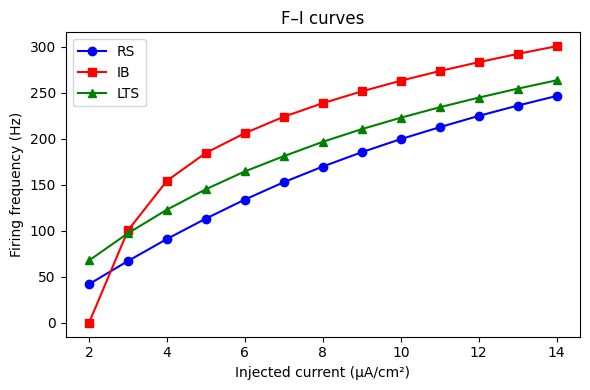

In [79]:
#plotting F-I curve

I_values = np.linspace(2,14,13)  # µA/cm²
RS_fI = compute_fI(RS_exc, RS_params,
                   lambda: [Vrest_RS,m0,h0,n0,p0], I_values)
IB_fI = compute_fI(IB_cell, IB_params,
                   lambda: [Vrest_IB,m0,h0,n0,p0,q0,r0], I_values)
# For LTS we skip hyperpolarization, just depolarizing step
LTS_fI = compute_fI(LTS_cell, LTS_params,
                    lambda: [Vrest_LTS,m0,h0,n0,p0,u0], I_values)

plt.figure(figsize=(6,4))
plt.plot(I_values, RS_fI, 'o-b', label='RS')
plt.plot(I_values, IB_fI, 's-r', label='IB')
plt.plot(I_values, LTS_fI, '^-g', label='LTS')
plt.xlabel('Injected current (µA/cm²)')
plt.ylabel('Firing frequency (Hz)')
plt.title('F–I curves')
plt.legend(); plt.tight_layout(); plt.show()



Now I will implement the Helper Functions. Let's start with the Baisc HH Kinetic Functions - Just the basic Actin Potential generation.

Now for the special Behaviour I want to model